In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch
import d2l

# Normal distribution: $p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right).$

In [4]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 * (x - mu)**2 / sigma**2)

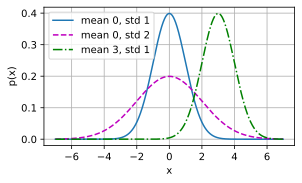

In [5]:
# Use NumPy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

One way to motivate linear regression with squared loss
is to assume that observations arise from noisy measurements,
where the noise $\epsilon$ follows the normal distribution 
$\mathcal{N}(0, \sigma^2)$:

$$y = \mathbf{w}^\top \mathbf{x} + b + \epsilon \textrm{ where } \epsilon \sim \mathcal{N}(0, \sigma^2).$$

Thus, we can now write out the *likelihood*
of seeing a particular $y$ for a given $\mathbf{x}$ via

$$P(y \mid \mathbf{x}) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (y - \mathbf{w}^\top \mathbf{x} - b)^2\right).$$

As such, the likelihood factorizes.
According to *the principle of maximum likelihood*,
the best values of parameters $\mathbf{w}$ and $b$ are those
that maximize the *likelihood* of the entire dataset:

$$P(\mathbf y \mid \mathbf X) = \prod_{i=1}^{n} p(y^{(i)} \mid \mathbf{x}^{(i)}).$$

The equality follows since all pairs $(\mathbf{x}^{(i)}, y^{(i)})$
were drawn independently of each other.
Estimators chosen according to the principle of maximum likelihood
are called *maximum likelihood estimators*.
While, maximizing the product of many exponential functions,
might look difficult,
we can simplify things significantly, without changing the objective,
by maximizing the logarithm of the likelihood instead.
For historical reasons, optimizations are more often expressed
as minimization rather than maximization.
So, without changing anything,
we can *minimize* the *negative log-likelihood*,
which we can express as follows:

$$-\log P(\mathbf y \mid \mathbf X) = \sum_{i=1}^n \frac{1}{2} \log(2 \pi \sigma^2) + \frac{1}{2 \sigma^2} \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b\right)^2.$$

# Poisson distribution: [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) 
captures distributions over counts. It is given by $p(k \mid \lambda) = \lambda^k e^{-\lambda}/k!$. 

Here $\lambda$ is the rate function and $k$ is the number of events you see. 

*likelihood* of the entire dataset:

$$P(\mathbf k \mid \mathbf \lambda) = \prod_{i=1}^{n} p(k^{(i)} \mid \mathbf{\lambda}^{(i)}).$$

negative Poisson log-likelihood: $$-\log P(\mathbf k \mid \mathbf \lambda) = \sum_i (1^T \lambda_i - k_i^T \log(\lambda_i + \epsilon)).$$

Depending on the noise in your data, choose the loss function accordingly!

In [7]:
class SyntheticRegressionData(d2l.DataModule):  #@save
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

In [8]:
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)

In [10]:
print('features:', data.X[0],'\nlabel:', data.y[0])

features: tensor([ 0.5401, -0.8672]) 
label: tensor([8.2369])


In [16]:
@d2l.add_to_class(d2l.DataModule)  #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size,
                                       shuffle=train)

@d2l.add_to_class(SyntheticRegressionData)  #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

In [17]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


In [20]:
def forward(X, w, b):
    return torch.matmul(X, w) + b

In [21]:
w = th.zeros((2,))
b = th.zeros((1,))

for batch in self.train_dataloader:
    loss = self.model.training_step(self.prepare_batch(batch))
    self.optim.zero_grad()
    with torch.no_grad():
        loss.backward()
        if self.gradient_clip_val > 0:  # To be discussed later
            self.clip_gradients(self.gradient_clip_val, self.model)
        self.optim.step()
    self.train_batch_idx += 1
if self.val_dataloader is None:
    return
self.model.eval()
for batch in self.val_dataloader:
    with torch.no_grad():
        self.model.validation_step(self.prepare_batch(batch))
    self.val_batch_idx += 1